<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/Agentic_Design_Patterns_with_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agentic Design Patterns with LangGraph

In [ ]:
!pip -qq install -U langchain langchain-community langgraph pydantic google-ai-generativelanguage==0.6.15 langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
import os
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage, HumanMessage

from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

## Prompt Chaining

In [ ]:
# Define LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are an expert technical writer. Always give clear,
     concise, and straight-to-the-point answers."""
)

# Define the graph state
class State(dict):
    text: str
    topics: str
    title: str

# Define nodes (steps)
def extract_topics(state: State) -> State:
    prompt = f"Extract 1-3 key topics from the following text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["topics"] = resp.content.strip()
    return state

def generate_title(state: State) -> State:
    prompt = f"Generate two catchy blog titles for each one these topics:\n\n{state['topics']}"
    resp = llm.invoke(prompt)
    state["title"] = resp.content.strip()
    return state

# Build the graph
workflow = StateGraph(State)
workflow.add_node("extract_topics", extract_topics)
workflow.add_node("generate_title", generate_title)

# Flow: extract_topics → generate_title → END
workflow.set_entry_point("extract_topics")
workflow.add_edge("extract_topics", "generate_title")
workflow.add_edge("generate_title", END)

# Compile runnable graph
graph = workflow.compile()

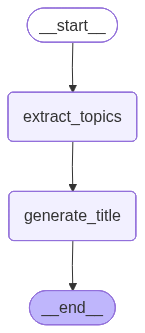

In [ ]:
graph

In [ ]:
# Run the graph
input_text = (
    "LangGraph introduces a graph-based paradigm for building LLM-powered agents. "
    "It allows developers to create modular, debuggable, and reliable agent workflows "
    "using nodes, edges, and state passing."
)

result = graph.invoke({"text": input_text})
print("Topics:", result["topics"])
print("\n"+"="*50+"\n")
print("Suggested Blog Title:", result["title"])

Topics: Here are 3 key topics extracted from the text:

1.  **Graph-based LLM Agents:** The core concept of using a graph structure to build LLM agents.
2.  **Modularity, Debuggability, and Reliability:** The benefits of using LangGraph for agent development.
3.  **Nodes, Edges, and State Passing:** The fundamental components of the LangGraph framework.


Suggested Blog Title: Okay, here are two catchy blog titles for each of the three topics, aiming for a mix of clarity and intrigue:

**1. Graph-based LLM Agents:**

*   **Title 1:** Unleashing the Power of Graph Minds: Building Smarter LLM Agents
*   **Title 2:** Beyond Chains: How Graph-Based Agents are Revolutionizing LLMs

**2. Modularity, Debuggability, and Reliability:**

*   **Title 1:** LangGraph: The Secret to Building Reliable and Debuggable LLM Agents
*   **Title 2:** Stop Chasing Bugs: LangGraph's Modular Approach to LLM Agent Development

**3. Nodes, Edges, and State Passing:**

*   **Title 1:** LangGraph Demystified: Node

## Routing

In [ ]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are a helpful assistant that can classify text
    sentiment and respond accordingly."""
)

# State definition
class State(dict):
    text: str
    sentiment: str
    response: str

# Nodes
def calssification(state: State) -> str:
    """Classify sentiment."""
    prompt = f"Is the following text positive or negative? Answer with one word only: Positive or Negative.\n\n{state['text']}"
    resp = llm.invoke(prompt)
    sentiment = resp.content.strip().lower()
    state["sentiment"] = sentiment
    return state

def positive_node(state: State) -> State:
    prompt = f"Generate an encouraging reply to this positive text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def negative_node(state: State) -> State:
    prompt = f"Generate a supportive reply to this negative text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def router_func(state: State) -> Literal["positive", "negative"]:
    """Return next node name."""
    return "positive" if "positive" in state["sentiment"] else "negative"

# Build the graph
workflow = StateGraph(State)

workflow.add_node("calssification", calssification)
workflow.add_node("positive", positive_node)
workflow.add_node("negative", negative_node)

# classify node decides the next step
workflow.set_entry_point("calssification")
workflow.add_conditional_edges("calssification", router_func, {
    "positive": "positive",
    "negative": "negative",
})

# Both branches lead to END
workflow.add_edge("positive", END)
workflow.add_edge("negative", END)

graph = workflow.compile()

In [ ]:
graph

In [ ]:
# Run example
input_text = "I'm so happy with how my project turned out!"
result = graph.invoke({"text": input_text})
print("Sentiment:", result["sentiment"])
print("Response:", result["response"])

Sentiment: positive
Response: That's fantastic to hear! So glad you're happy with how your project turned out. All your hard work really paid off! What are you most proud of?


## Parallelization

In [ ]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

# State definition
class State(TypedDict):
    text: str
    # Reducer makes these append-only so multiple nodes can update in parallel
    outputs: Annotated[list, operator.add]

# Nodes
def summarize(state: State):
    prompt = f"Summarize in one sentence:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Summary: {resp.content.strip()}"]}

def critique(state: State):
    prompt = f"Critique briefly:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Critique: {resp.content.strip()}"]}

def combine(state: State):
    prompt = f"Combine the following Critique and Summarization in one \
    paragraph:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Combined:\n{resp.content.strip()}"]}

# Build the graph
builder = StateGraph(State)
builder.add_node("summarize", summarize)
builder.add_node("critique", critique)
builder.add_node("combine", combine)

# Parallel edges: summarize and critique run side by side
builder.add_edge(START, "summarize")
builder.add_edge(START, "critique")

# Both join into combine
builder.add_edge("summarize", "combine")
builder.add_edge("critique", "combine")

builder.add_edge("combine", END)

graph = builder.compile()

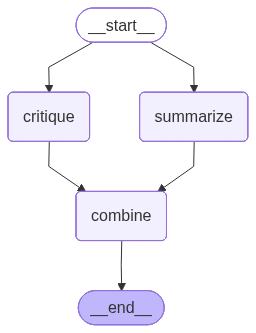

In [ ]:
graph

In [ ]:
# --- Run example ---
input_text = "LangGraph helps developers design and run agent workflows with LLMs."
result = graph.invoke({"text": input_text, "outputs": []})

print("\nFinal outputs:")
for out in result["outputs"]:
    print(out)
    print("="*100 + "\n")


Final outputs:
Critique: The statement is accurate and concise, but lacks detail and context. Here's a brief critique, highlighting its strengths and weaknesses:

**Strengths:**

*   **Accurate:** It correctly identifies LangGraph's primary function.
*   **Concise:** It's a short and to-the-point description.

**Weaknesses:**

*   **Lacks Specificity:** Doesn't explain *how* LangGraph helps, what kind of workflows, or its advantages.
*   **Missing Context:** Assumes the reader knows what "agent workflows" and "LLMs" are.
*   **Doesn't Highlight Value Proposition:** Doesn't mention benefits like improved reliability, observability, or scalability.

**In essence, it's a functional description, not a compelling one.** It tells you *what* LangGraph does, but not *why* it's useful or *how* it's different.

Summary: LangGraph is a framework for building multi-actor workflows powered by large language models.

Combined:
LangGraph provides a powerful framework for developers to construct and 

## Reflection

In [ ]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

# State
class State(TypedDict):
    task: str
    draft: str
    feedback: str
    final: str

# Nodes
def generator(state: State):
    """Generate an initial or refined draft."""
    prompt = f"""
You are an assistant helping to complete the following task:

Task:
{state['task']}

Current Draft:
{state.get('draft', 'None')}

Feedback:
{state.get('feedback', 'None')}

Instructions:
- If there is no draft and no feedback, generate a clear and complete response to the task.
- If there is a draft but no feedback, improve the draft as needed for clarity and quality.
- If there is both a draft and feedback, revise the draft by incorporating the feedback directly.
- Always produce a single, improved draft as your output.
"""
    resp = llm.invoke(prompt)
    return {"draft": resp.content.strip()}

def evaluator(state: State):
    """Evaluate the draft and give feedback or approval."""
    prompt = f"""Evaluate the following draft, based on the given task.
If it meets the requirements, reply exactly 'APPROVED'.
Otherwise, provide constructive feedback for improvement.
Task:
{state['task']}
Draft:
{state['draft']}"""
    resp = llm.invoke(prompt)
    print(f"""
================= DRAFT =================
{state['draft']}

================ FEEDBACK ===============
{resp.content.strip()}
========================================
""")
    return {"feedback": resp.content.strip()}

def decide(state: State) -> str:
    """Decide next step: either approve and finish, or refine again."""
    if "APPROVED" in state["feedback"].upper():
        return "approved"
    return "refine"

def finalize(state: State):
    """Save the final approved draft."""
    return {"final": state["draft"]}

# Build the graph
builder = StateGraph(State)

builder.add_node("generator", generator)
builder.add_node("evaluator", evaluator)
builder.add_node("finalize", finalize)

builder.add_edge(START, "generator")
builder.add_edge("generator", "evaluator")
builder.add_edge("evaluator", "finalize")

# Conditional edges from decide
builder.add_conditional_edges(
    "evaluator",
    decide,
    {
        "approved": "finalize",   # stop loop
        "refine": "generator",    # go back for improvement
    },
)

builder.add_edge("finalize", END)

graph = builder.compile()

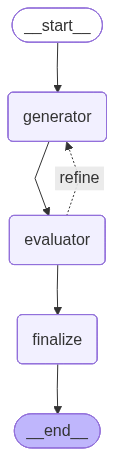

In [ ]:
graph

In [ ]:
# Run example
input_task = "You have six horses and want to race them to see which is fastest. What is the best way to do this?"
result = graph.invoke({"task": input_task})

print("\nFinal Answer:\n", result["final"])


================= DRAFT =================
Here's a strategy to determine the fastest horse out of six, minimizing the number of races required:

1. **Initial Races:** Divide the six horses into two groups of three. Race each group. Label the horses A1, A2, A3 (with A1 being the fastest in the first race, A2 second, and A3 third) and B1, B2, B3 (similarly ranked from the second race).

2. **Race of the Winners:** Race the winners of the two initial races (A1 and B1). The winner of this race is the fastest horse overall. Let's say A1 wins.

3. **Determining Second Fastest:** The second fastest horse could be either B1 (the horse that lost to A1 in the winners' race) or A2 (the second-place horse from the race that A1 won). Race B1 and A2. The winner of *this* race is the second-fastest horse overall.

Therefore, this method requires a total of three races.

================ FEEDBACK ===============
The draft is incorrect. While it identifies the fastest horse correctly, it fails to reli

## Tool Use

In [ ]:
# State definition
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a simple tool
def calculator(expression: str):
    """Evaluate a math expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"

# Initialize Gemini model with tools
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

model_with_tools = llm.bind_tools([calculator])
tool_node = ToolNode([calculator])

# Nodes
def call_model(state: State):
    """Call the model; it may request a tool."""
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: State):
    """Decide whether to go to tools or finish."""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # If the model requested a tool
        return "tools"
    return END

# Build the graph
builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue, ["tools", END])
builder.add_edge("tools", "call_model")

graph = builder.compile()

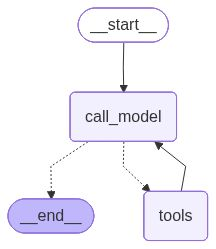

In [ ]:
graph

In [ ]:
# Run example
query = {"role": "user", "content": "What is 12 * 7?"}
result = graph.invoke({"messages": [query]})

print("\nConversation:")
for m in result["messages"]:
    print(m)


Conversation:
content='What is 12 * 7?' additional_kwargs={} response_metadata={} id='5ceeda02-510d-4bad-849a-759212097013'
content='' additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"expression": "12 * 7"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--b8c8ab73-5082-47c0-9bd9-8e46b2ae3ad1-0' tool_calls=[{'name': 'calculator', 'args': {'expression': '12 * 7'}, 'id': '662e4855-57d9-4304-be72-923b453c8577', 'type': 'tool_call'}] usage_metadata={'input_tokens': 19, 'output_tokens': 7, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}}
content='84' name='calculator' id='6354a43a-c65e-44b2-84b5-2a575a7b3cf2' tool_call_id='662e4855-57d9-4304-be72-923b453c8577'
content='The answer is 84.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--dd0f2241-aab6-4412-b

## Planning

Simulated workers and response for brevity, but in real application, workers would be react agents or more complex workflows.

The key difference from Routing is that the Planner generates a multi-step plan rather than selecting a single next step.

In [ ]:
# Set up the Language Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

# Define the State
# We need separate fields for each worker's results.
class PlannerState(TypedDict):
    task: str
    plan: list[str]
    graphql_results: str  # Results from the GraphQL researcher
    rest_results: str     # Results from the REST researcher
    final_output: str     # The final written summary

# Define the Tools and Workers

# Dummy tools for our researchers
def graphql_search_tool(query: str):
    """A dummy tool that returns fixed info about GraphQL."""
    print(f"GRAPHQL RESEARCHER: Searching for '{query}'")
    return "GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema."

def rest_search_tool(query: str):
    """A dummy tool that returns fixed info about REST."""
    print(f"REST RESEARCHER: Searching for '{query}'")
    return "REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid."

# Worker Nodes
def graphql_research_worker(state: PlannerState):
    """Worker node that researches GraphQL pros."""
    results = graphql_search_tool("pros of GraphQL")
    return {"graphql_results": results}

def rest_research_worker(state: PlannerState):
    """Worker node that researches REST cons."""
    results = rest_search_tool("cons of REST APIs")
    return {"rest_results": results}

def writer_worker(state: PlannerState):
    """
    Synthesizer node that waits for all research and writes the final output.
    This node acts as the "join" point.
    """
    print("WRITER: Synthesizing results")
    graphql_results = state['graphql_results']
    rest_results = state['rest_results']

    writing_prompt = f"""
    Write a short, balanced comparison post based on the following research.

    GraphQL Information:
    {graphql_results}

    REST API Information:
    {rest_results}
    """
    response = llm.invoke(writing_prompt)
    return {"final_output": response.content}

# Define the Planner
def planner(state: PlannerState):
    """Planner node that creates the initial plan."""
    print("PLANNER: Creating a plan for parallel execution")
    # For this example, the plan is hardcoded.
    # In a real app, an LLM would generate this based on the task.
    plan = [
        "Research GraphQL pros",
        "Research REST cons",
        "Write comparison post"
    ]
    return {"plan": plan}

# Build the Graph
workflow = StateGraph(PlannerState)

# Add the nodes
workflow.add_node("planner", planner)
workflow.add_node("graphql_researcher", graphql_research_worker)
workflow.add_node("rest_researcher", rest_research_worker)
workflow.add_node("writer", writer_worker)

# Set the entry point
workflow.set_entry_point("planner")

# Define the parallel edges
# After the planner, both research workers are called.
workflow.add_edge("planner", "graphql_researcher")
workflow.add_edge("planner", "rest_researcher")

# Define the join point
# The writer will only run after BOTH research workers are complete.
workflow.add_edge("graphql_researcher", "writer")
workflow.add_edge("rest_researcher", "writer")

# The graph ends after the writer is done
workflow.add_edge("writer", END)

# Compile the graph
graph = workflow.compile()

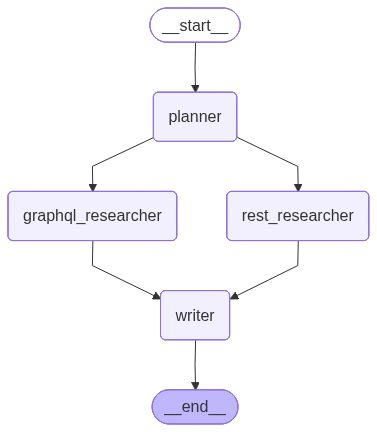

In [ ]:
graph

In [ ]:
# Run the Graph
user_task = "Write a short post comparing the pros of GraphQL with the cons of REST APIs."
initial_state = {"task": user_task}

# Stream the events to see the execution flow
for event in graph.stream(initial_state):
    for key, value in event.items():
        print(f"Node '{key}' output:")
        print("---")
        print(value)
        print("\n" + "="*30 + "\n")

# Get the final output
final_state = graph.invoke(initial_state)
print("Final Comparison Post:")
print(final_state['final_output'])

PLANNER: Creating a plan for parallel execution
Node 'planner' output:
---
{'plan': ['Research GraphQL pros', 'Research REST cons', 'Write comparison post']}


GRAPHQL RESEARCHER: Searching for 'pros of GraphQL'
Node 'graphql_researcher' output:
---
{'graphql_results': 'GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema.'}


REST RESEARCHER: Searching for 'cons of REST APIs'
Node 'rest_researcher' output:
---
{'rest_results': 'REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid.'}


WRITER: Synthesizing results
Node 'writer' output:
---
{'final_output': '## GraphQL vs. REST: A Quick Comparison\n\nChoosing the right API architecture is crucial for efficient data handling. Both GraphQL and REST offer solutions, but cater to different needs and priorities.\n\n**GraphQL shines with its:**\n\n*   **Efficient Data Fetching:** GraphQL allows clients to request 

## Multi-agent

In this example, we will use the `Command` Class instead of conditional edges, just to showcase that we can both update the graph state and route to a different node simultaniously.
This is very useful when desining complex multi-agent architectures.


In [ ]:
# Set up the Language Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

# Define the Supervisor's Routing Logic

# This Pydantic model helps the supervisor choose the next agent.
class Router(BaseModel):
    """Decide the next agent to route to."""
    next_agent: Literal["Weather", "Flights", "__end__"]

# Bind the router to the model to get structured output.
supervisor_model = llm.with_structured_output(Router)

def supervisor(state: MessagesState) -> Command:
    """
    The central supervisor that routes to the correct agent or ends the conversation.
    """
    print("--- 🧑‍💼 SUPERVISOR ---")

    # The prompt tells the supervisor how to route the user's message.
    prompt = f"""You are a supervisor routing tasks to a specialist agent.
    Based on the user's request, choose the appropriate agent.

    Available agents:
    - Weather: For questions about weather forecasts.
    - Flights: For questions about flight information.

    If the user is saying thank you or the conversation is over, choose '__end__'.

    User message: "{state['messages'][-1].content}"
    """
    if isinstance(state['messages'][-1], HumanMessage):
      # The supervisor model makes the routing decision.
      response = supervisor_model.invoke(prompt)
      print(f"Supervisor routing to: {response.next_agent}")
      return Command(goto=response.next_agent)
    else:
      return Command(goto='__end__')

# Define the Specialist Agents

def weather_agent(state: MessagesState) -> Command:
    """A specialist agent for handling weather-related queries."""
    print("--- ☀️ WEATHER AGENT ---")

    prompt = f"""You are a weather forecaster. Provide a concise mock weather forecast
    for the location mentioned in the user's message.

    User message: "{state['messages'][-1].content}"
    """
    response = llm.invoke(prompt)
    print(f"Response: {response.content}")
    # Return to the supervisor after the agent has run.
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def flights_agent(state: MessagesState) -> Command:
    """A specialist agent for handling flight-related queries."""
    print("--- ✈️ FLIGHTS AGENT ---")

    prompt = f"""You are a flight information assistant. Provide some mock flight
    details for the destination in the user's message. Respond with short concise information.

    User message: "{state['messages'][-1].content}"
    """
    response = llm.invoke(prompt)
    print(f"Response: {response.content}")
    # Return to the supervisor after the agent has run.
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

# Build the Graph

builder = StateGraph(MessagesState)

# Add the supervisor and agents as nodes in the graph.
builder.add_node("supervisor", supervisor)
builder.add_node("Weather", weather_agent)
builder.add_node("Flights", flights_agent)

# The START node directs the flow to the supervisor first.
builder.add_edge(START, "supervisor")

# The graph is now complete. The `Command` objects will handle the dynamic routing.
graph = builder.compile()

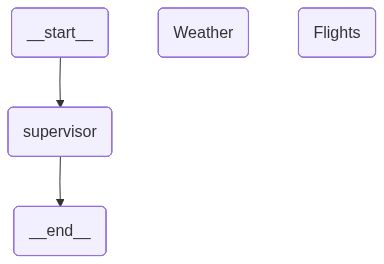

In [ ]:
graph

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # The graph.stream() method invokes the graph and streams the results.
    events = graph.stream({"messages":[HumanMessage(content=user_input)]})
    for event in events:
        # We only print the AI's responses to the user.
        if "messages" in event:
            event["messages"][-1].pretty_print()

User: What's the weather in Tunisia?
--- 🧑‍💼 SUPERVISOR ---
Supervisor routing to: Weather
--- ☀️ WEATHER AGENT ---
Response: Good morning, Tunisia! Expect a sunny day across most of the country. Temperatures will be warm, ranging from the mid-20s Celsius along the coast to the low 30s inland. A light breeze will keep things comfortable along the Mediterranean. Enjoy the sunshine!
--- 🧑‍💼 SUPERVISOR ---
User: Is there any flights from Tunisia to USA available today?
--- 🧑‍💼 SUPERVISOR ---
Supervisor routing to: Flights
--- ✈️ FLIGHTS AGENT ---
Response: Yes, there are flights available.

*   **Airline:** Lufthansa
*   **Departure:** Tunis (TUN) 10:00 AM
*   **Arrival:** New York (JFK) 6:00 PM (Next Day)
*   **Stops:** Frankfurt (FRA)
*   **Price:** $850
--- 🧑‍💼 SUPERVISOR ---
User: thank you
--- 🧑‍💼 SUPERVISOR ---
Supervisor routing to: __end__
User: q
Goodbye!


## Final Notes:
There are several other patterns that are more advanced, but the ones we've seen here are the most commonly used ones, and that you can find in arguably all agentic architectures.

LangGraph has prebuilt functions for defining agents that can be useful to avoid repetitiveness, for example:
- `create_react_agent`: Create a react agent
- `create_supervisor`: Create a supervisor for mult-agent architectures
- `create_swarm`: Create swarm multi-agent systems with tool hand-offs.